In [6]:
from typing import List
import sklearn.metrics.pairwise as sklearn_pairwise
from sklearn.neighbors import KNeighborsClassifier
import cv2
import numpy as np
from sklearn.cluster import KMeans
import random
import time
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import kmeans,vq
import matplotlib.pyplot as plt

In [1]:
#!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Load data

In [1]:
!git clone https://github.com/Sejmou/ml-ex3.git

fatal: destination path 'ml-ex3' already exists and is not an empty directory.


In [4]:
ls

ml-ex3/  sample_data/


In [5]:
import sys
sys.path.append('./ml-ex3/')# make script files in ml-ex3 accessible

In [7]:
from data_loaders import GTSRBLoader

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = GTSRBLoader('./data').get_processed_imgs(target_width = 50, target_height = 50, normalize=False, convert_to_grayscale=True)# cannot resize to 257 directly, our implementation is too RAM-hungry

GTSRB dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


In [9]:
X_train_int = X_train.astype(np.uint8)
X_test_int = X_test.astype(np.uint8)
del X_train
del X_test

## Extract Sift keypoints

In [10]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color),
                       cmap='gray', vmin=0, vmax=255)

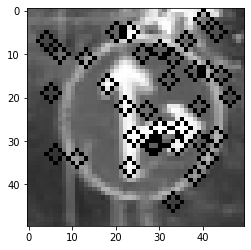

In [11]:
sift=cv2.xfeatures2d.SIFT_create()
kp = sift.detect(X_train_int[1],None)
kp, des = sift.compute(X_train_int[1], kp)
img=draw_keypoints(X_train_int[1],kp)

In [12]:
def extract_dsift(images):
    sift = cv2.xfeatures2d.SIFT_create()
    
    all_descriptors = []
    nans = set()
    for i in range(len(images)):
        image = images[i]
        kp = sift.detect(image,None)
        kp, des = sift.compute(image, kp)

        if des is not None:
          all_descriptors.append(des)
        else:
          nans.add(i)

    print(len(nans))
    return all_descriptors, nans

In [13]:
sift_features, nans = extract_dsift(X_train_int)
all_descriptors = np.vstack(sift_features)

1932


In [14]:
kmeans = KMeans(n_clusters=20).fit(all_descriptors)

### Creating histogram of training image

In [15]:
def count_visual_words(dense_feat: List[np.ndarray], centroids: List[np.ndarray]) -> List[np.ndarray]:
    histograms = []

    for k in range(0, len(dense_feat)):
        distances = sklearn_pairwise.pairwise_distances(dense_feat[k], centroids)
        clusters = np.argmin(distances, axis=1)
        histogram = np.histogram(clusters, bins = range(len(centroids)))
        histograms.append(histogram[0])

    return histograms

In [16]:
histograms_train = count_visual_words(sift_features, kmeans.cluster_centers_)

In [17]:
def get_data_without_nan(data, nan):
  without_nan = []

  for i in range(len(data)):
    if i not in nan:
      without_nan.append(y_train[i])
      
  return without_nan

In [18]:
y_train_sift = get_data_without_nan(y_train, nans)

In [19]:
classifier = KNeighborsClassifier(n_neighbors=5).fit(histograms_train, y_train_sift)

### Testing the Classification Model

In [20]:
prediction_train = classifier.predict(histograms_train)

In [21]:
score = classifier.score(histograms_train, y_train_sift)

In [22]:
print(score)

0.5681978521595986


In [23]:
test_descriptors, test_nan = extract_dsift(X_test_int)
test_histograms = count_visual_words(test_descriptors, kmeans.cluster_centers_)
prediction_test = classifier.predict(test_histograms)

881


In [24]:
y_test_sift = get_data_without_nan(y_test, test_nan)

In [25]:
len(y_test_sift)

11749

In [26]:
score = classifier.score(test_histograms, y_test_sift)

In [27]:
print(score)

0.03872670014469316
